In [32]:
# ----- Core Python & Visualization ----- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Data Preprocessing ----- #
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ----- Models ----- #
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# ----- Evaluation Metrics ----- #
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, accuracy_score

# ----- Neural Network (Keras) ----- #
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [33]:
df = pd.read_csv('/Users/anhuynh/Downloads/dc.csv')

df

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972
...,...,...,...,...,...,...,...,...,...,...
995,2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227
996,2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
997,2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
998,2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533


Data Visualization

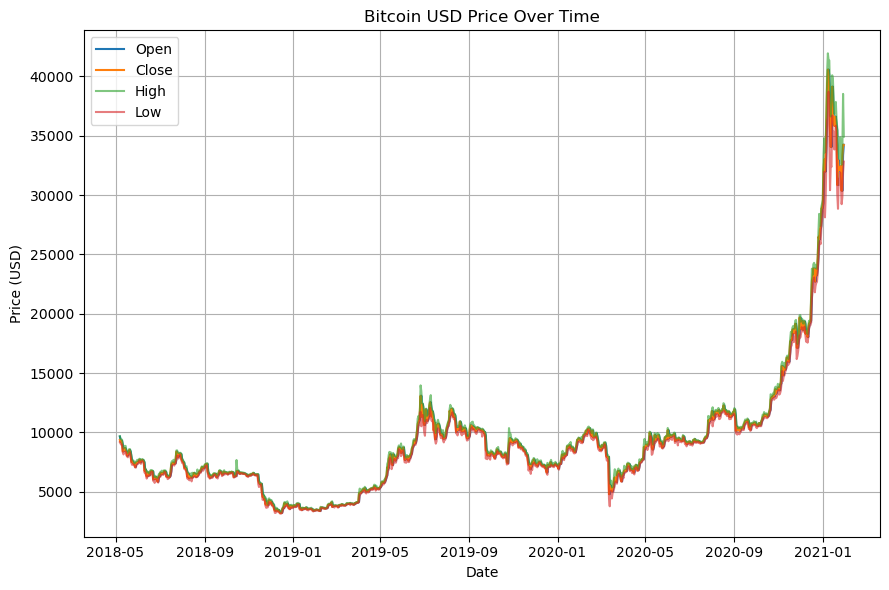

In [34]:
df["date"] = pd.to_datetime(df["Unnamed: 0"])
df.set_index('date', inplace=True)

plt.figure(figsize=(9, 6))
plt.plot(df.index, df["open_USD"], label="Open")
plt.plot(df.index, df["close_USD"], label="Close")
plt.plot(df.index, df["high_USD"], label="High", alpha=0.6)
plt.plot(df.index, df["low_USD"], label="Low", alpha=0.6)
plt.title("Bitcoin USD Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Starting in 2020, there is a noticeable sharp rise in Bitcoin prices, following more modest trends in earlier years. A potential major driver of this surge has been the approval of Bitcoin exchange-traded funds (ETFs) by the U.S. financial regulator in January, allowing investors to trade Bitcoin more easily through traditional markets. Additionally, the strong correlation between the open, close, high, and low values suggests that Bitcoin experienced relatively consistent daily trading ranges during this period, with minimal intraday volatility.

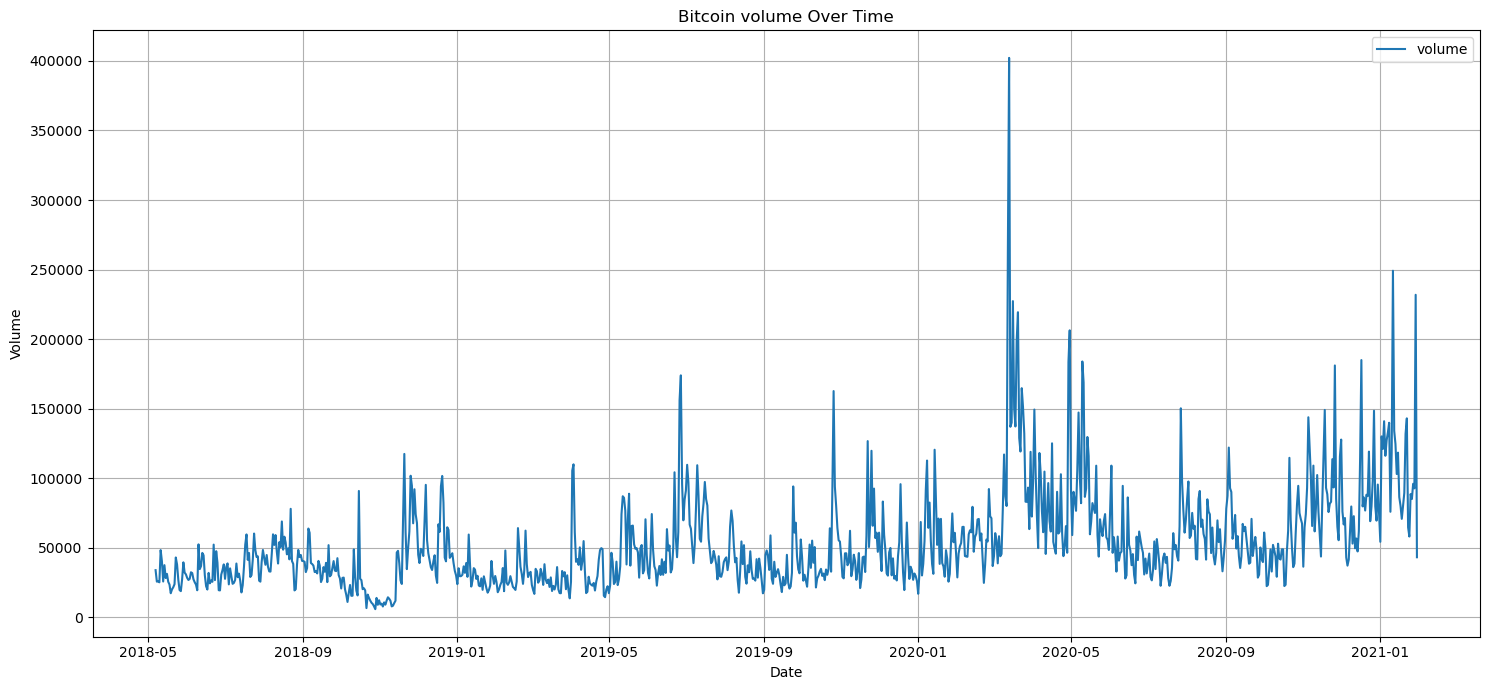

In [35]:
#volume graph

plt.figure(figsize=(15, 7))
plt.plot(df.index, df["volume"], label="volume")
plt.title("Bitcoin volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

After visualizing the volume data, we can see a significant peak in April 2020. This spike may be attributed to the pandemic-related shutdowns and subsequent government policies, which heightened investors' concerns about the global economy and likely accelerated Bitcoin’s rise in popularity and trading activity.

Model Preparation, Architecture, Train/testing

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['close_USD']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60 #look back
X, y = create_sequences(scaled_data, window_size)

# Reshape for RNN input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train/Test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 2.1365e-04
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.9842e-04 - val_loss: 1.7811e-04
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.7269e-04 - val_loss: 1.6896e-04
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.0167e-04 - val_loss: 1.6502e-04
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.5380e-04 - val_loss: 1.6767e-04
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.2939e-04 - val_loss: 1.4379e-04
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.2712e-04 - val_loss: 1.7081e-04
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.3938e-04 - val_loss: 1.3532e-04
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.4510e-04 - val_loss: 1.3452e-04


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


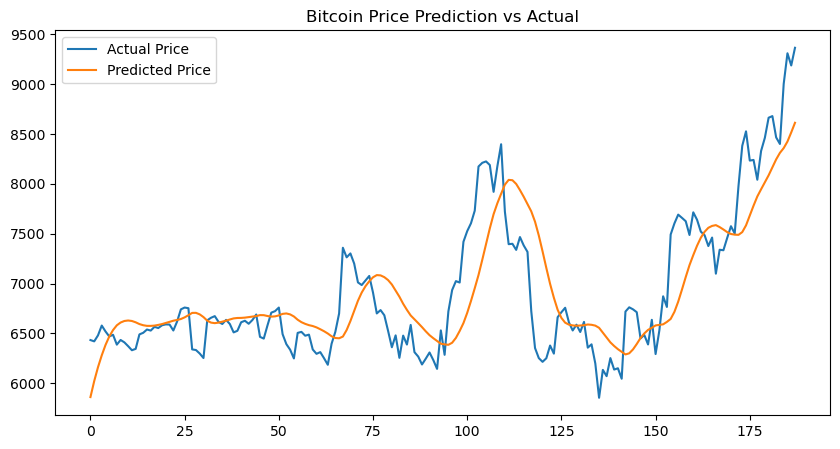

In [38]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('Bitcoin Price Prediction vs Actual')
plt.legend()
plt.show()


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Scale a single-column series
def scale_series(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series)
    return scaled, scaler

# Time-based train-test split
def split_time_series(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    return data[:train_size], data[train_size:]

# Create lagged sequences for supervised learning
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape for RNN input: (samples, timesteps, features)
def reshape_for_rnn(X):
    return np.reshape(X, (X.shape[0], X.shape[1], 1))


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform

def build_rnn_model(input_shape, units=50, dropout=0.2, seed=42):
    model = Sequential([
        SimpleRNN(units, activation='tanh',
                  input_shape=input_shape,
                  kernel_initializer=GlorotUniform(seed=seed)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_shape, units=50, dropout=0.2, seed=42):
    model = Sequential([
        LSTM(units, activation='tanh',
             input_shape=input_shape,
             kernel_initializer=GlorotUniform(seed=seed)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [41]:
from tensorflow.keras.callbacks import EarlyStopping

def run_grid_search(train, test, param_grid, build_model_fn, model_name="LSTM"):
    results = []

    for look_back in param_grid['look_back']:
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = reshape_for_rnn(trainX)
        testX = reshape_for_rnn(testX)

        for units in param_grid['units']:
            for dropout in param_grid['dropout']:
                model = build_model_fn((look_back, 1), units=units, dropout=dropout)

                history = model.fit(
                    trainX, trainY,
                    validation_data=(testX, testY),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
                )

                preds = model.predict(testX, verbose=0)
                mse = mean_squared_error(testY, preds)

                results.append({
                    'model': model_name,
                    'look_back': look_back,
                    'units': units,
                    'dropout': dropout,
                    'val_mse': mse
                })

    return pd.DataFrame(results).sort_values(by="val_mse")


In [42]:
# 1. Prepare your data
df["date"] = pd.to_datetime(df["Unnamed: 0"])
df.set_index("date", inplace=True)

btc = df[["close_USD"]]
btc_scaled, btc_scaler = scale_series(btc)
train, test = split_time_series(btc_scaled)

# 2. Define search space
param_grid = {
    'look_back': [30, 60, 90],
    'units': [32, 64],
    'dropout': [0.1, 0.2]
}

# 3. Run grid search
results_rnn = run_grid_search(train, test, param_grid, build_rnn_model, model_name="SimpleRNN")





/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

In [43]:
results_lstm = run_grid_search(train, test, param_grid, build_lstm_model, model_name="LSTM")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

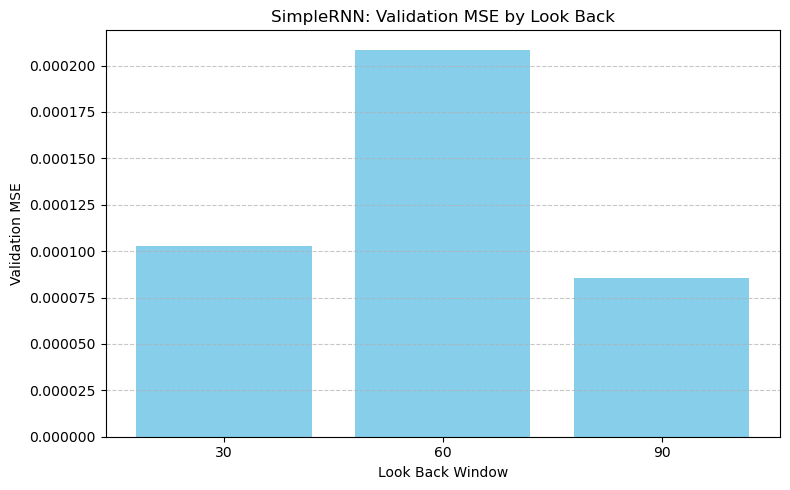

In [50]:
# Sort results_rnn by look_back
results_rnn_sorted = results_rnn.sort_values(by='look_back')

plt.figure(figsize=(8, 5))
plt.bar(results_rnn_sorted['look_back'].astype(str), results_rnn_sorted['val_mse'], color='skyblue')
plt.title("SimpleRNN: Validation MSE by Look Back")
plt.xlabel("Look Back Window")
plt.ylabel("Validation MSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



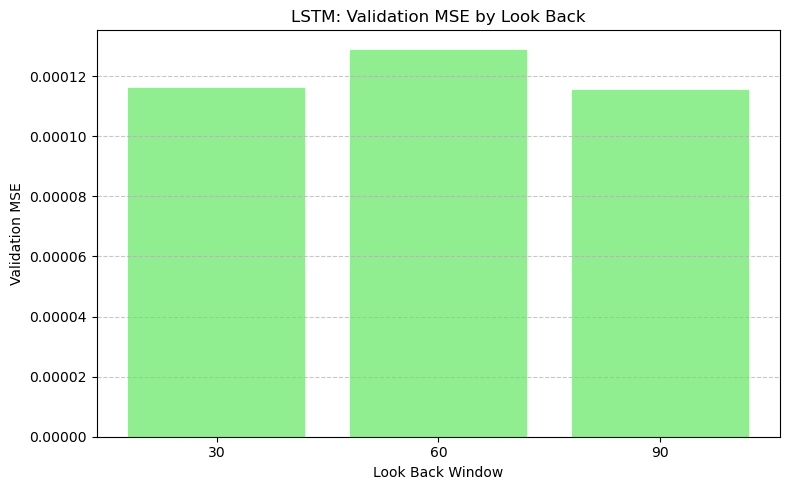

In [49]:
# Sort results_lstm by look_back
results_lstm_sorted = results_lstm.sort_values(by='look_back')

plt.figure(figsize=(8, 5))
plt.bar(results_lstm_sorted['look_back'].astype(str), results_lstm_sorted['val_mse'], color='lightgreen')
plt.title("LSTM: Validation MSE by Look Back")
plt.xlabel("Look Back Window")
plt.ylabel("Validation MSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [54]:
# Get best configuration for SimpleRNN
best_config = results_rnn.sort_values(by="val_mse").iloc[0]
print("🔍 Best SimpleRNN Configuration:")
print(best_config)


🔍 Best SimpleRNN Configuration:
model        SimpleRNN
look_back           90
units               64
dropout            0.1
val_mse       0.000048
Name: 10, dtype: object


In [55]:
# Get best configuration for SimpleRNN
best_config = results_lstm.sort_values(by="val_mse").iloc[0]
print("🔍 Best LSTM Configuration:")
print(best_config)

🔍 Best LSTM Configuration:
model            LSTM
look_back          90
units              32
dropout           0.1
val_mse      0.000095
Name: 8, dtype: object


In [56]:
# Recreate dataset for best look_back
best_look_back = int(best_config['look_back'])
trainX, trainY = create_dataset(train, best_look_back)
testX, testY = create_dataset(test, best_look_back)

trainX = reshape_for_rnn(trainX)
testX = reshape_for_rnn(testX)

# Retrain the best model
best_model = build_rnn_model(
    input_shape=(best_look_back, 1),
    units=int(best_config['units']),
    dropout=float(best_config['dropout'])
)

best_model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=30,
    batch_size=32,
    verbose=0,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

preds = best_model.predict(testX)
     
     

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


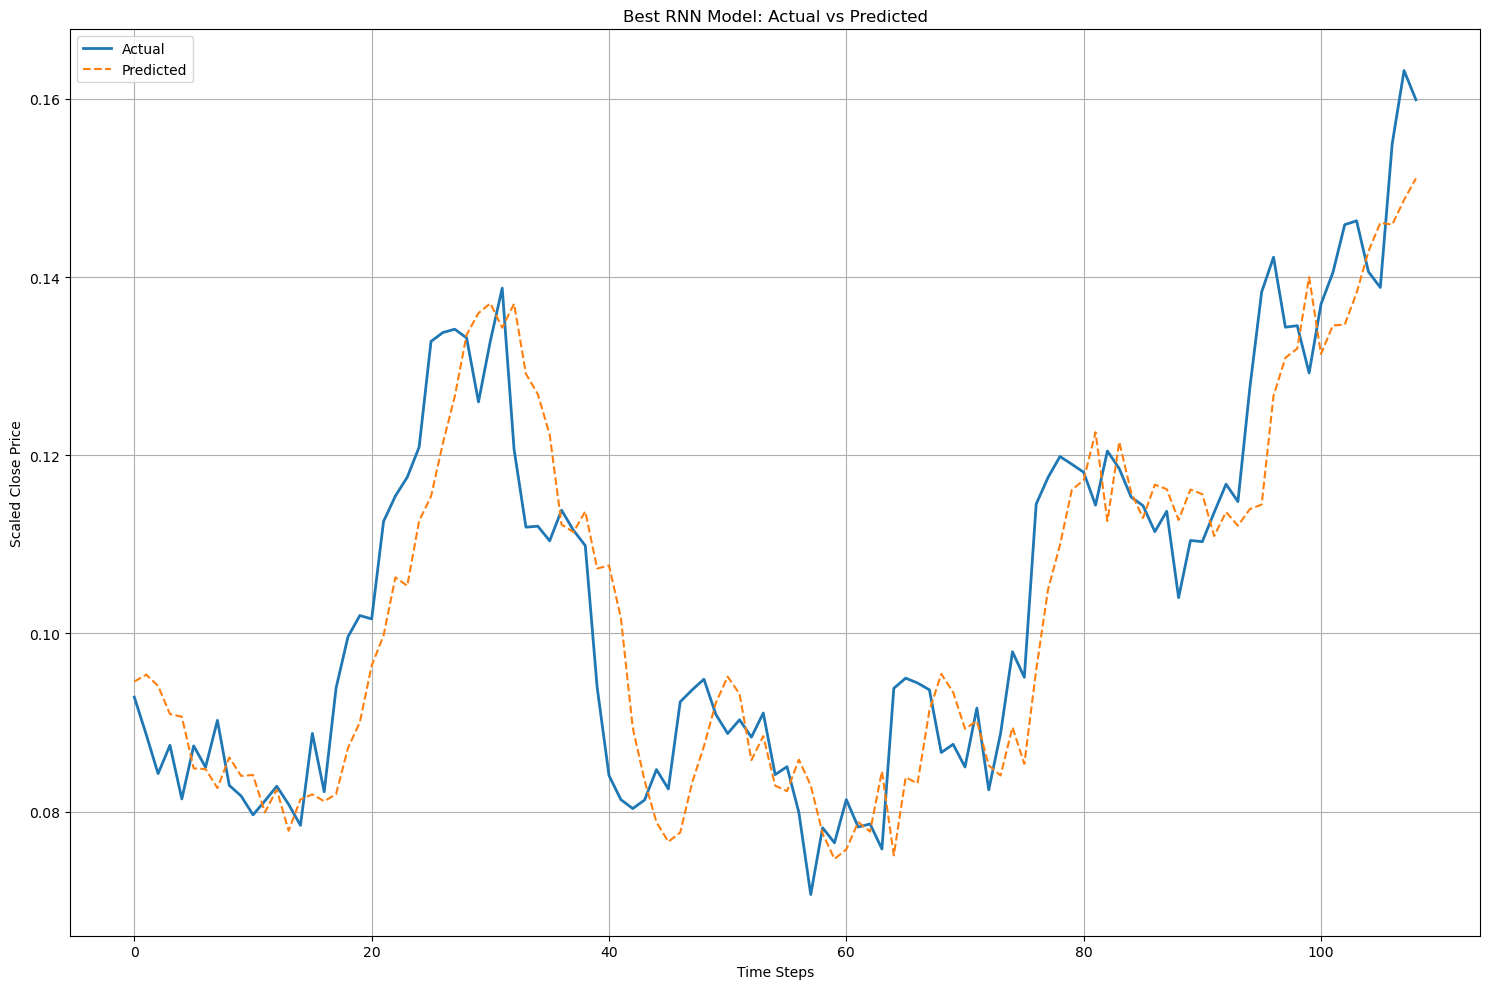

In [59]:
# Plot actual vs predicted
plt.figure(figsize=(15, 10))
plt.plot(testY, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title("Best RNN Model: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

After running multiple models using different configurations and three types of input data, I found that the best-performing model was a SimpleRNN with a look-back window of 90 days, 64 hidden units, and a dropout rate of 0.1. This configuration achieved the lowest validation mean squared error (MSE) of 0.000048, indicating that it produced the most accurate predictions among all tested models. This model's predicted Bitcoin closing prices were very close to the actual values, making it highly effective for short-term forecasting in this case.